In [2]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation , Angle
# importing photutils to select a circular region of rad r around x, y
from photutils.aperture import CircularAperture, aperture_photometry

In [98]:
file = fits.open('yedb8.fit')
file.info()

Filename: yedb8.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


In [99]:
file[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  765 /fastest changing axis                           
NAXIS2  =                  510 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2025-03-14T23:57:38' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =  0.20000000000000001 /Exposure time in seconds                        
EXPOSURE=  0.20000000000000001 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -9.3729062676215307 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

In [100]:
date_obs_ut=file[0].header['DATE-OBS']
exptime=file[0].header['EXPTIME']
ped_offset_corr=file[0].header['PEDESTAL']
gain = file[0].header['EGAIN']
print('date and time:',date_obs_ut)
print('exposure time in sec:',exptime)
print('pedestal offset correction:',ped_offset_corr)
print('gain in electron per adu',gain)

date and time: 2025-03-14T23:57:38
exposure time in sec: 0.2
pedestal offset correction: -100
gain in electron per adu 2.5799999237060547


In [101]:
# calculation of zenith angle
ra_hms = (16,19,39.8)      # Right Ascension in (hours, minutes, seconds)
dec_dms = (-4,45,23.1)   # Declination in (degrees, minutes, seconds)
latitude = 18.5592         # Observer's latitude in degrees 
longitude = 73.8253        # Observer's longitude in degrees
utc_time = date_obs_ut  # UTC time of observation

# Convert RA (hours, min, sec) to degrees
ra = Angle(f"{ra_hms[0]}h{ra_hms[1]}m{ra_hms[2]}s").degree  # RA in degrees

# Convert Dec (deg, min, sec) to decimal degrees
dec = Angle(f"{dec_dms[0]}d{dec_dms[1]}m{dec_dms[2]}s").degree  # Dec in degrees

# Convert Dec and Latitude to radians
dec = np.radians(dec)
latitude = np.radians(latitude)

# Compute Local Sidereal Time (LST)
time = Time(utc_time)
location = EarthLocation.from_geodetic(lon=longitude, lat=latitude)
lst = time.sidereal_time("apparent", longitude).degree  # LST in degrees

# Convert LST and RA to radians
lst_rad = np.radians(lst)
ra_rad = np.radians(ra)

# Compute Hour Angle (H = LST - RA) in radians
H = lst_rad - ra_rad

# Apply the cosine formula for the zenith angle
cos_Z = np.sin(latitude) * np.sin(dec) + np.cos(latitude) * np.cos(dec) * np.cos(H)

# Ensure cos_Z is within valid range [-1,1] for arccos
cos_Z = np.clip(cos_Z, -1, 1)

# Compute Zenith Angle (Z) in degrees
Z = np.degrees(np.arccos(cos_Z))

print(f"Zenith Angle: {Z:.2f} degrees")

Zenith Angle: 23.34 degrees


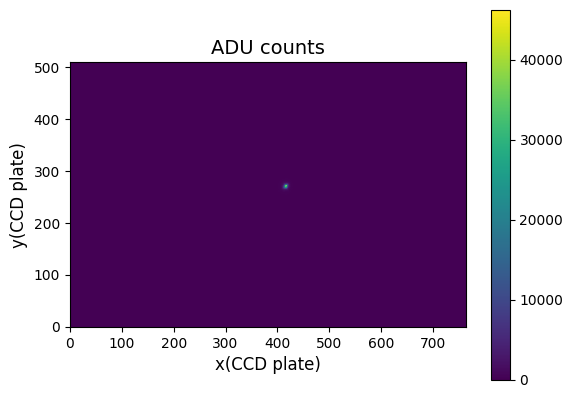

array([[112, 103, 102, ..., 116, 101,  91],
       [ 96, 107, 125, ..., 108, 120, 124],
       [112,  99, 100, ..., 105, 103, 110],
       ...,
       [105, 102, 100, ..., 106, 105, 113],
       [110, 103, 101, ..., 105, 101, 104],
       [121,  97, 110, ..., 112, 109, 101]], dtype=uint16)

In [102]:
image = file[0].data
plt.xlabel("x(CCD plate)", fontsize=12)
plt.ylabel("y(CCD plate)", fontsize=12)
plt.title("ADU counts", fontsize=14)
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()
image

[[ 46.43999863  11.60999966   7.73999977 ...  61.91999817   3.86999989
  -34.82999897]
 [-15.47999954  27.0899992   96.74999714 ...  30.95999908  77.39999771
   92.87999725]
 [ 46.43999863  -3.86999989   0.         ...  19.34999943  11.60999966
   38.69999886]
 ...
 [ 19.34999943   7.73999977   0.         ...  23.21999931  19.34999943
   50.30999851]
 [ 38.69999886  11.60999966   3.86999989 ...  19.34999943   3.86999989
   15.47999954]
 [ 81.2699976  -11.60999966  38.69999886 ...  46.43999863  34.82999897
    3.86999989]]


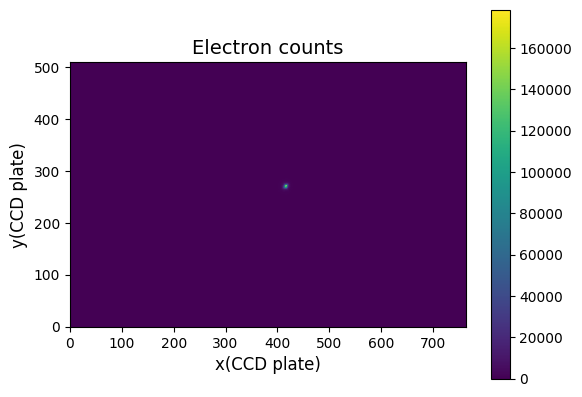

In [103]:
e_count= ((image*1.0)+ped_offset_corr)*gain #pedestal corrected electron counts
e_count= (e_count/exptime)*0.3 #scaling for uniform exposure time = electron counts per 0.3 second
print(e_count)
plt.imshow(e_count, origin='lower')
plt.xlabel("x(CCD plate)", fontsize=12)
plt.ylabel("y(CCD plate)", fontsize=12)
plt.title("Electron counts", fontsize=14)
plt.colorbar()
plt.show()

In [104]:
# center of source
max_value = np.max(e_count) # max electron count value
max_index = np.unravel_index(np.argmax(e_count), e_count.shape) # indices of max counts
print(e_count.shape)
print(f"Maximum Value: {max_value}")
print(f"Indices of Maximum Value: {max_index}")  # Output as (row, column) (y,x)

(510, 765)
Maximum Value: 178472.7847223282
Indices of Maximum Value: (271, 416)


counts of source plus backgound =  [ 510415.76947505 1710396.42017201 2997348.10835781 4114139.7432766
 4976632.30858473 5593474.16349572 6018500.50546225 6303061.69379186
 6497671.93189721 6636424.39217294 6738352.1982926  6813782.00026436
 6871090.21485037 6915979.75678396]


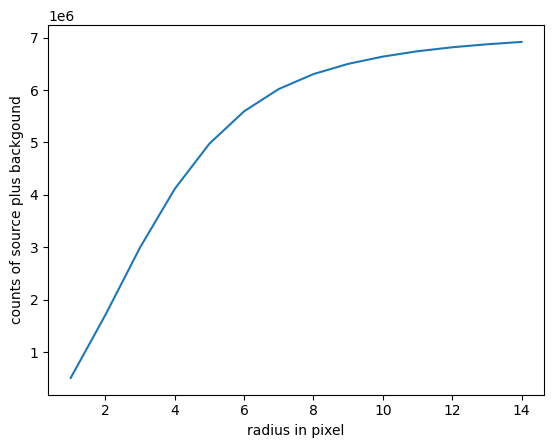

In [105]:
pos = (max_index[1],max_index[0]) # source center
# changing the radius and plotting counts vs px

electron_counts = [] 
radius= np.arange(1,15,1)

for i in radius:
    aper = CircularAperture(pos, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts.append(each_table['aperture_sum'].value)

electron_counts = (np.array(electron_counts)).flatten()
print('counts of source plus backgound = ',electron_counts)

plt.plot(radius, electron_counts)
plt.ylabel('counts of source plus backgound')
plt.xlabel('radius in pixel')
#plt.yscale('log')
plt.show()

counts of source =  [ 510281.47378619 1709957.08984697 2996501.62761478 4112968.63728572
 4975308.29830754 5591748.43652121 6016010.27865658 6299546.17565302
 6493101.37630897 6630704.62248225 6731839.05116697 6806156.12682419
 6861921.6281638  6905283.4988319 ]


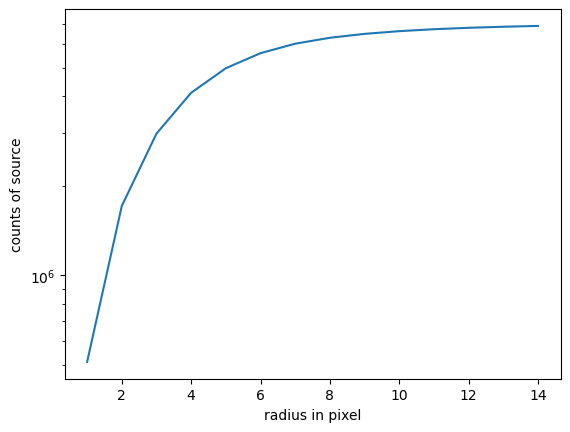

In [106]:
pos_bkg = (max_index[1]-100,max_index[0]-100) #bacground center for this source(in vicinity of source)

electron_counts_bkg = [] 

for i in radius:
    aper = CircularAperture(pos_bkg, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts_bkg.append(each_table['aperture_sum'].value)

electron_counts_bkg = (np.array(electron_counts_bkg)).flatten() 
electron_counts_source= electron_counts-electron_counts_bkg
print('counts of source = ',electron_counts_source)

plt.plot(radius, electron_counts_source)
plt.ylabel('counts of source')
plt.xlabel('radius in pixel')
plt.yscale('log')
plt.show()

In [107]:
# defining region of radius r around src and bkg

r=8
src_plus_bkg= electron_counts[r-1]
bkg= electron_counts_bkg[r-1]

print('source plus bkg count=',src_plus_bkg); print('background count=',bkg)

flux = src_plus_bkg - bkg
mag = -2.5*np.log10(flux)
sec= 1.0/np.cos(np.radians(Z))
print('magnitude= ',mag,'zenith angle in degrees= ',Z,'sec z=',sec)

source plus bkg count= 6303061.693791859
background count= 3515.5181388428846
magnitude=  -16.99827315914631 zenith angle in degrees=  23.3440376540323 sec z= 1.0891560332806152


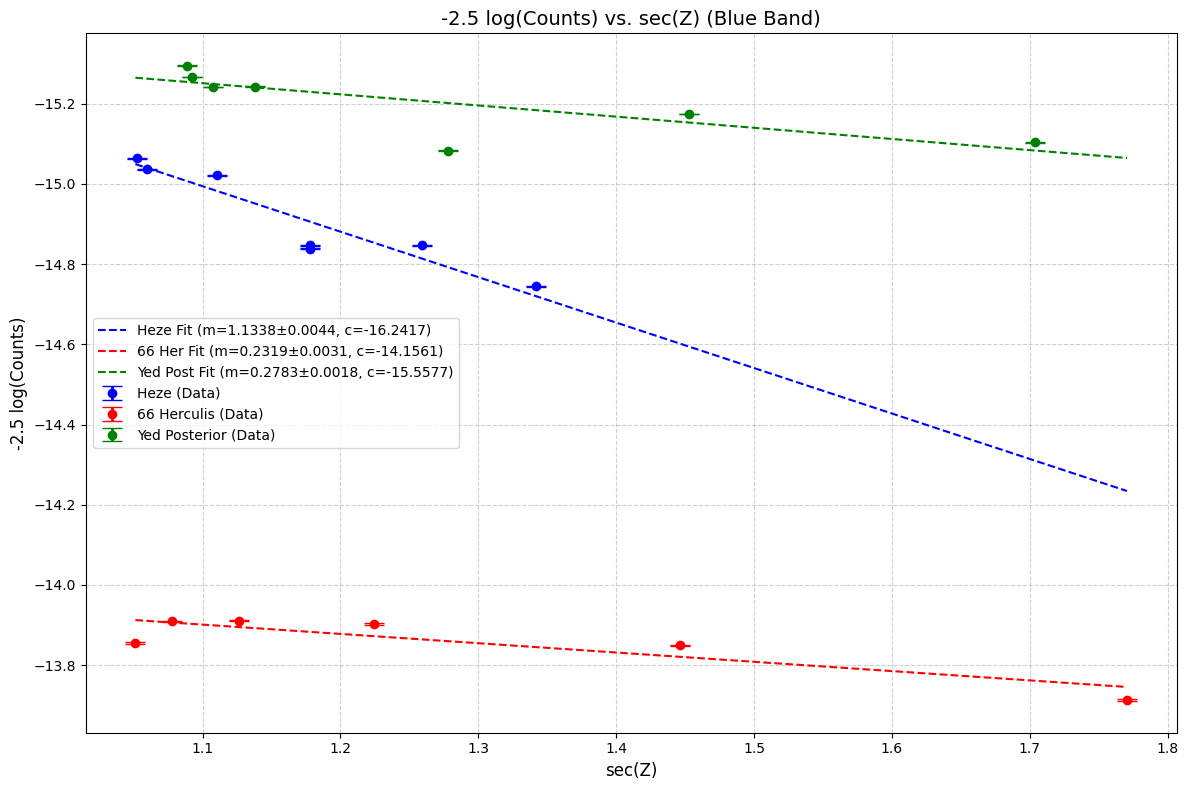

Atmospheric Extinction Correction in Blue band with Errors
Heze: a_blue = 1.1338 ± 0.0044
66 Herculis: a_blue = 0.2319 ± 0.0031
Yed Posterior: a_blue = 0.2783 ± 0.0018
resultant value= 0.5480 ± 0.0384


In [97]:
# Heze
mag_hezeb = np.array([-14.83806485, -15.06376485, -15.03696485, -15.02186485, -14.84746485, -14.84766485, -14.74436485])
secz_hezeb = np.array([1.1777, 1.0526, 1.0596, 1.1102, 1.1781, 1.2593, 1.3416])
counts_heze = 10**(-0.4 * mag_hezeb)
error_counts_heze = np.sqrt(counts_heze)
error_mag_heze = (2.5 / np.log(10)) * (error_counts_heze / counts_heze)

# 66 Herculis
mag_66b = np.array([-13.71256485, -13.84906485, -13.90236485, -13.91096485, -13.90926485, -13.85526485])
secz_66b = np.array([1.7705, 1.4462, 1.2241, 1.1264, 1.0778, 1.0513])
counts_66 = 10**(-0.4 * mag_66b)
error_counts_66 = np.sqrt(counts_66)
error_mag_66 = (2.5 / np.log(10)) * (error_counts_66 / counts_66)

# Yed Posterior
mag_yedb = np.array([-15.10426485, -15.17446485, -15.08336485, -15.24246485, -15.24216485, -15.26706485, -15.29556485])
secz_yedb = np.array([1.7038, 1.4531, 1.2781, 1.1380, 1.1078, 1.0921, 1.0891])
counts_yed = 10**(-0.4 * mag_yedb)
error_counts_yed = np.sqrt(counts_yed)
error_mag_yed = (2.5 / np.log(10)) * (error_counts_yed / counts_yed)

# Weighted Linear Fit
def weighted_fit(x, y, errors):
    weights = 1 / errors**2
    m, c = np.polyfit(x, y, 1, w=weights)
    return m, c

m_heze, c_heze = weighted_fit(secz_hezeb, mag_hezeb, error_mag_heze)
m_66, c_66 = weighted_fit(secz_66b, mag_66b, error_mag_66)
m_yed, c_yed = weighted_fit(secz_yedb, mag_yedb, error_mag_yed)

# Calculate error in slope
def slope_error(x, y, errors):
    weights = 1 / errors**2
    x_w = np.sum(weights * x) / np.sum(weights)
    D = np.sum(weights * (x - x_w)**2)
    return np.sqrt(1 / D)

error_m_heze = slope_error(secz_hezeb, mag_hezeb, error_mag_heze)
error_m_66 = slope_error(secz_66b, mag_66b, error_mag_66)
error_m_yed = slope_error(secz_yedb, mag_yedb, error_mag_yed)

# Generate fitted lines
fit_secz = np.linspace(min(secz_yedb.tolist() + secz_66b.tolist() + secz_hezeb.tolist()), 
                      max(secz_yedb.tolist() + secz_66b.tolist() + secz_hezeb.tolist()), 100)
fit_mag_heze = m_heze * fit_secz + c_heze
fit_mag_66 = m_66 * fit_secz + c_66
fit_mag_yed = m_yed * fit_secz + c_yed

# Plot
plt.figure(figsize=(12,8))
plt.errorbar(secz_hezeb, mag_hezeb, yerr=error_mag_heze, fmt='o', color='blue', 
             label="Heze (Data)", capsize=7, elinewidth=2, markeredgewidth=1)
plt.errorbar(secz_66b, mag_66b, yerr=error_mag_66, fmt='o', color='red', 
             label="66 Herculis (Data)", capsize=7, elinewidth=2, markeredgewidth=1)
plt.errorbar(secz_yedb, mag_yedb, yerr=error_mag_yed, fmt='o', color='green', 
             label="Yed Posterior (Data)", capsize=7, elinewidth=2, markeredgewidth=1)

plt.plot(fit_secz, fit_mag_heze, color='blue', linestyle='--', 
         label=f"Heze Fit (m={m_heze:.4f}±{error_m_heze:.4f}, c={c_heze:.4f})")
plt.plot(fit_secz, fit_mag_66, color='red', linestyle='--', 
         label=f"66 Her Fit (m={m_66:.4f}±{error_m_66:.4f}, c={c_66:.4f})")
plt.plot(fit_secz, fit_mag_yed, color='green', linestyle='--', 
         label=f"Yed Post Fit (m={m_yed:.4f}±{error_m_yed:.4f}, c={c_yed:.4f})")

plt.xlabel("sec(Z)", fontsize=12)
plt.ylabel("-2.5 log(Counts)", fontsize=12)
plt.title("-2.5 log(Counts) vs. sec(Z) (Blue Band)", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

m = (m_66+m_yed+m_heze)/3.0
error = np.sqrt((error_m_66**2 + error_m_yed**2+error_m_heze)/3.0)
# Print results
print("Atmospheric Extinction Correction in Blue band with Errors")
print(f"Heze: a_blue = {m_heze:.4f} ± {error_m_heze:.4f}")
print(f"66 Herculis: a_blue = {m_66:.4f} ± {error_m_66:.4f}")
print(f"Yed Posterior: a_blue = {m_yed:.4f} ± {error_m_yed:.4f}")
print(f"resultant value= {m:.4f} ± {error:.4f}") 

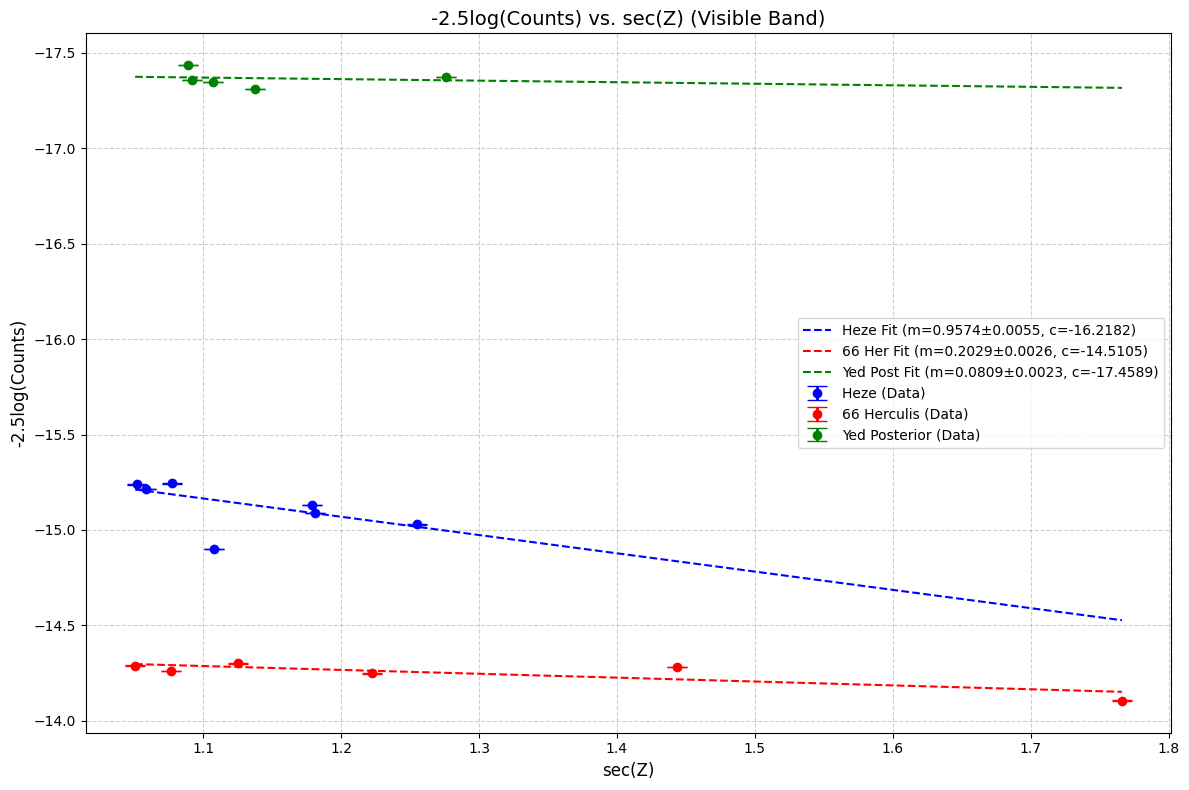

Atmospheric Extinction Correction in Visible band with Errors
Heze: a_visible = 0.9574 ± 0.0055
66 Herculis: a_visible = 0.2029 ± 0.0026
Yed Posterior: a_visible = 0.0809 ± 0.0023
resultant value= 0.4137 ± 0.0428


In [4]:
# Heze (Visible band)
mag_hezev = np.array([-15.13006485, -15.24376485, -15.23876485, -15.21386485,-14.90106485, -15.08886485, -15.02946485])
secz_hezev = np.array([1.1790, 1.0778, 1.0520, 1.0584, 1.1081, 1.1811, 1.2552])
counts_heze = 10**(-0.4 * mag_hezev)
error_counts_heze = np.sqrt(counts_heze)
error_mag_heze = (2.5 / np.log(10)) * (error_counts_heze / counts_heze)

# 66 Herculis (Visible band)
mag_66v = np.array([-14.10606485, -14.28226485, -14.24836485, -14.30116485, -14.26086485, -14.28946485])
secz_66v = np.array([1.7662, 1.4436, 1.2226, 1.1253, 1.0770, 1.0507])
counts_66 = 10**(-0.4 * mag_66v)
error_counts_66 = np.sqrt(counts_66)
error_mag_66 = (2.5 / np.log(10)) * (error_counts_66 / counts_66)

# Yed Posterior (Visible band)
mag_yedv = np.array([-17.3709,-17.3110,-17.3461,-17.3552,-17.4348])
secz_yedv = np.array([1.2764,1.1373,1.1073,1.0920,1.0892])
counts_yed = 10**(-0.4 * mag_yedv)
error_counts_yed = np.sqrt(counts_yed)
error_mag_yed = (2.5 / np.log(10)) * (error_counts_yed / counts_yed)

# Weighted Linear Fit
def weighted_fit(x, y, errors):
    weights = 1 / errors**2
    m, c = np.polyfit(x, y, 1, w=weights)
    return m, c

m_heze, c_heze = weighted_fit(secz_hezev, mag_hezev, error_mag_heze)
m_66, c_66 = weighted_fit(secz_66v, mag_66v, error_mag_66)
m_yed, c_yed = weighted_fit(secz_yedv, mag_yedv, error_mag_yed)

# Calculate error in slope
def slope_error(x, y, errors):
    weights = 1 / errors**2
    x_w = np.sum(weights * x) / np.sum(weights)
    D = np.sum(weights * (x - x_w)**2)
    return np.sqrt(1 / D)

error_m_heze = slope_error(secz_hezev, mag_hezev, error_mag_heze)
error_m_66 = slope_error(secz_66v, mag_66v, error_mag_66)
error_m_yed = slope_error(secz_yedv, mag_yedv, error_mag_yed)

# Generate fitted lines
fit_secz = np.linspace(min(secz_yedv.tolist() + secz_66v.tolist() + secz_hezev.tolist()), 
                      max(secz_yedv.tolist() + secz_66v.tolist() + secz_hezev.tolist()), 100)
fit_mag_heze = m_heze * fit_secz + c_heze
fit_mag_66 = m_66 * fit_secz + c_66
fit_mag_yed = m_yed * fit_secz + c_yed

# Plot
plt.figure(figsize=(12,8))
plt.errorbar(secz_hezev, mag_hezev, yerr=error_mag_heze, fmt='o', color='blue', 
             label="Heze (Data)", capsize=7, elinewidth=2, markeredgewidth=1)
plt.errorbar(secz_66v, mag_66v, yerr=error_mag_66, fmt='o', color='red', 
             label="66 Herculis (Data)", capsize=7, elinewidth=2, markeredgewidth=1)
plt.errorbar(secz_yedv, mag_yedv, yerr=error_mag_yed, fmt='o', color='green', 
             label="Yed Posterior (Data)", capsize=7, elinewidth=2, markeredgewidth=1)

plt.plot(fit_secz, fit_mag_heze, color='blue', linestyle='--', 
         label=f"Heze Fit (m={m_heze:.4f}±{error_m_heze:.4f}, c={c_heze:.4f})")
plt.plot(fit_secz, fit_mag_66, color='red', linestyle='--', 
         label=f"66 Her Fit (m={m_66:.4f}±{error_m_66:.4f}, c={c_66:.4f})")
plt.plot(fit_secz, fit_mag_yed, color='green', linestyle='--', 
         label=f"Yed Post Fit (m={m_yed:.4f}±{error_m_yed:.4f}, c={c_yed:.4f})")

plt.xlabel("sec(Z)", fontsize=12)
plt.ylabel("-2.5log(Counts)", fontsize=12)
plt.title("-2.5log(Counts) vs. sec(Z) (Visible Band)", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

m = (m_66+m_yed+m_heze)/3.0
error = np.sqrt((error_m_66**2 + error_m_yed**2 + error_m_heze)/3.0)

# Print results
print("Atmospheric Extinction Correction in Visible band with Errors")
print(f"Heze: a_visible = {m_heze:.4f} ± {error_m_heze:.4f}")
print(f"66 Herculis: a_visible = {m_66:.4f} ± {error_m_66:.4f}")
print(f"Yed Posterior: a_visible = {m_yed:.4f} ± {error_m_yed:.4f}")
print(f"resultant value= {m:.4f} ± {error:.4f}")